In [55]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import wandb

from dawgz import job, after, ensure, schedule
from itertools import chain, islice
from pathlib import Path
from torch import Tensor
Tensor
from tqdm import tqdm
from typing import *
import pandas as pd

from lampe.data import H5Dataset
from zuko.distributions import BoxUniform
from lampe.inference import NPE, NPELoss
from lampe.nn import ResMLP
from zuko.flows import NAF, NSF, MAF, NCSF, SOSPF, UNAF, CNF 
from lampe.plots import nice_rc, corner, coverage_plot, mark_point
from lampe.utils import GDStep

import sys
sys.path.insert(0, '/home/mvasist/Highres/simulations/')
from DataProcuring import Data 
from ProcessingSpec import ProcessSpec
from parameter import *
from spectra_simulator import SpectrumMaker
from parameter_set_script import param_set, param_list, param_list_ext, param_set_ext, deNormVal
# from spectra_simulator import Simulator, LOWER, UPPER
# from AverageEstimator import avgestimator

# sys.path.insert(0, '/home/mvasist/Highres/sbi/added_scripts/')
from added_scripts.corner_modified import *
from added_scripts.pt_plotting import *


# from ees import Simulator, LOWER, UPPER, LABELS, pt_profile
LABELS, LOWER, UPPER = zip(*[
[                  r'$FeH$',  -1.5, 1.5],   # temp_node_9
[                  r'$CO$',  0.1, 1.6],  # CO_mol_scale
[                  r'$\log g$',   2.5, 5.5],          # log g
[                  r'$Tint$',  300,   3500],   # temp_node_5
[                  r'$T1$',  300,   3500],      # T_bottom
[                  r'$T2$',  300,   3500],   # temp_node_1
[                  r'$T3$',  300,   3500],   # temp_node_2
[                  r'$alpha$',  1.0, 2.0],   # temp_node_4
[                  r'$log_delta$', 3.0, 8.0],   # temp_node_3
[                  r'$log_Pquench$', -6.0, 3.0],   # temp_node_6
[                  r'$logFe$',  -2.3, 1.0], # CH4_mol_scale
[                  r'$fsed$',  0.0, 10.0],   # temp_node_8
[                  r'$logKzz$',  5.0, 13.0], # H2O_mol_scale \_mol\_scale
[                  r'$sigmalnorm$',  1.05, 3.0], # C2O_mol_scale
[                  r'$log\_iso\_rat$',  -11.0, -1.0],   # temp_node_7
[                  r'$R\_P$', 0.8, 2.0],             # R_P / R_Jupyter
[                  r'$rv$',  10.0, 30.0], # NH3_mol_scale 20, 35
[                  r'$vsini$', 0.0, 50 ], # H2S_mol_scale 10.0, 30.0
[                  r'$limb\_dark$',  0.0, 1.0], # PH3_mol_scale
[                  r'$b$',  1, 20.0], # PH3_mol_scale

])

os.environ['SCRATCH'] = os.path.join('/scratch/users/mvasist/')
scratch = os.environ['SCRATCH']
datapath = Path(scratch) / 'highres-sbi/data_nic5'
savepath = Path(scratch) / 'highres-sbi/runs/sweep_lognormnoise'

processing = ProcessSpec()
d = Data()
sim = SpectrumMaker(wavelengths=d.model_wavelengths, param_set=param_set, lbl_opacity_sampling=2)


def simulator(theta):
    values = theta[:-4].numpy()
    values_ext = theta[-4:].numpy()
    # print(values, values_ext)
    values_actual = deNormVal(values, param_list)
    spectrum = sim(values_actual)
    spec = np.vstack((np.array(spectrum), d.model_wavelengths))
    
    values_ext_actual = deNormVal(values_ext, param_list_ext)
    # params_ext = param_set_ext.param_dict(values_ext_actual)
    
    th, x = processing(torch.Tensor([values_actual]), torch.Tensor(spec), sample= False, \
                       values_ext_actual= torch.Tensor([values_ext_actual]))
    # print(np.shape(x))
    return x.squeeze()


## Loading from a model to plot
CONFIGS = {
    'embedding': ['shallow'],
    'flow': ['MAF'],  #, 'NCSF', 'SOSPF', 'UNAF', 'CNF'], #'NAF', 
    'transforms': [3], #, 7], #3, 
    # 'signal': [16, 32],  # not important- the autoregression network output , 32
    'hidden_features': [512], # hidden layers of the autoregression network , 256, 
    'hidden_features_no' : [5], 
    'activation': [nn.ELU], #, nn.ReLU],
    'optimizer': ['AdamW'],
    'init_lr':  [1e-3], #[5e-4, 1e-5]
    'weight_decay': [1e-4], #[1e-4], #
    'scheduler': ['ReduceLROnPlateau'], #, 'CosineAnnealingLR'],
    'min_lr': [1e-5], # 1e-6
    'patience': [16], #8
    'epochs': [350],
    'stop_criterion': ['early'], #, 'late'],
    'batch_size':  [256],
    'spectral_length' : [6144], #[1536, 3072, 6144]
    'factor' : [0.3], 
    'noise_scaling' : [2], 
    'noise' : ['lognormaldist']
    # 'SOSF_degree' : [2,3,4],
    # 'SOSF_poly' : [2,4,6],
}



/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:113: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [3]:
d = Data()

In [4]:
scratch = os.environ.get('SCRATCH', '')
datapath = Path(scratch) / 'highres-sbi/runs/sweep_lognormnoise' 

runpath = datapath / 'honest-totem-81'
ep = 900
savepath = runpath/ ('plots_' + str(ep))


In [5]:
df_theta = pd.read_csv(savepath/'theta.csv')
theta = df_theta.values
theta = torch.from_numpy(theta)
# theta = theta*(torch.Tensor(UPPER)-torch.Tensor(LOWER)) + torch.Tensor(LOWER)


In [6]:
# x_star =  torch.Tensor(np.loadtxt('/home/mvasist/Highres/observation/simulated_obs/x_sim_b.npy'))[0]
# theta_star = torch.Tensor(np.loadtxt('/home/mvasist/Highres/observation/simulated_obs/theta_sim_b.npy'))

In [10]:
# plt.rcParams.update(nice_rc(latex=True))
# plt.figure(figsize=(15,7))
# # plt.errorbar(x[0, 1], x[0,0], yerr= d.err**d.flux_scaling*25, color = 'steelblue', label = 'betsfit')
# plt.plot(d.data_wavelengths_norm, d.flux*d.flux_scaling, color = 'black')
# plt.xlabel('Wavelength (mu)', fontsize = 20)
# plt.ylabel('Planet flux Fv (meanflux Wm-2 um-1)', fontsize= 20)
# plt.show()

In [12]:
## Sam's retrieval

theta_sam = torch.load('/home/mvasist/Highres/Sam/Model_2/Mine/posterior.pth')

In [13]:
th_df = pd.DataFrame(theta[:20469])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


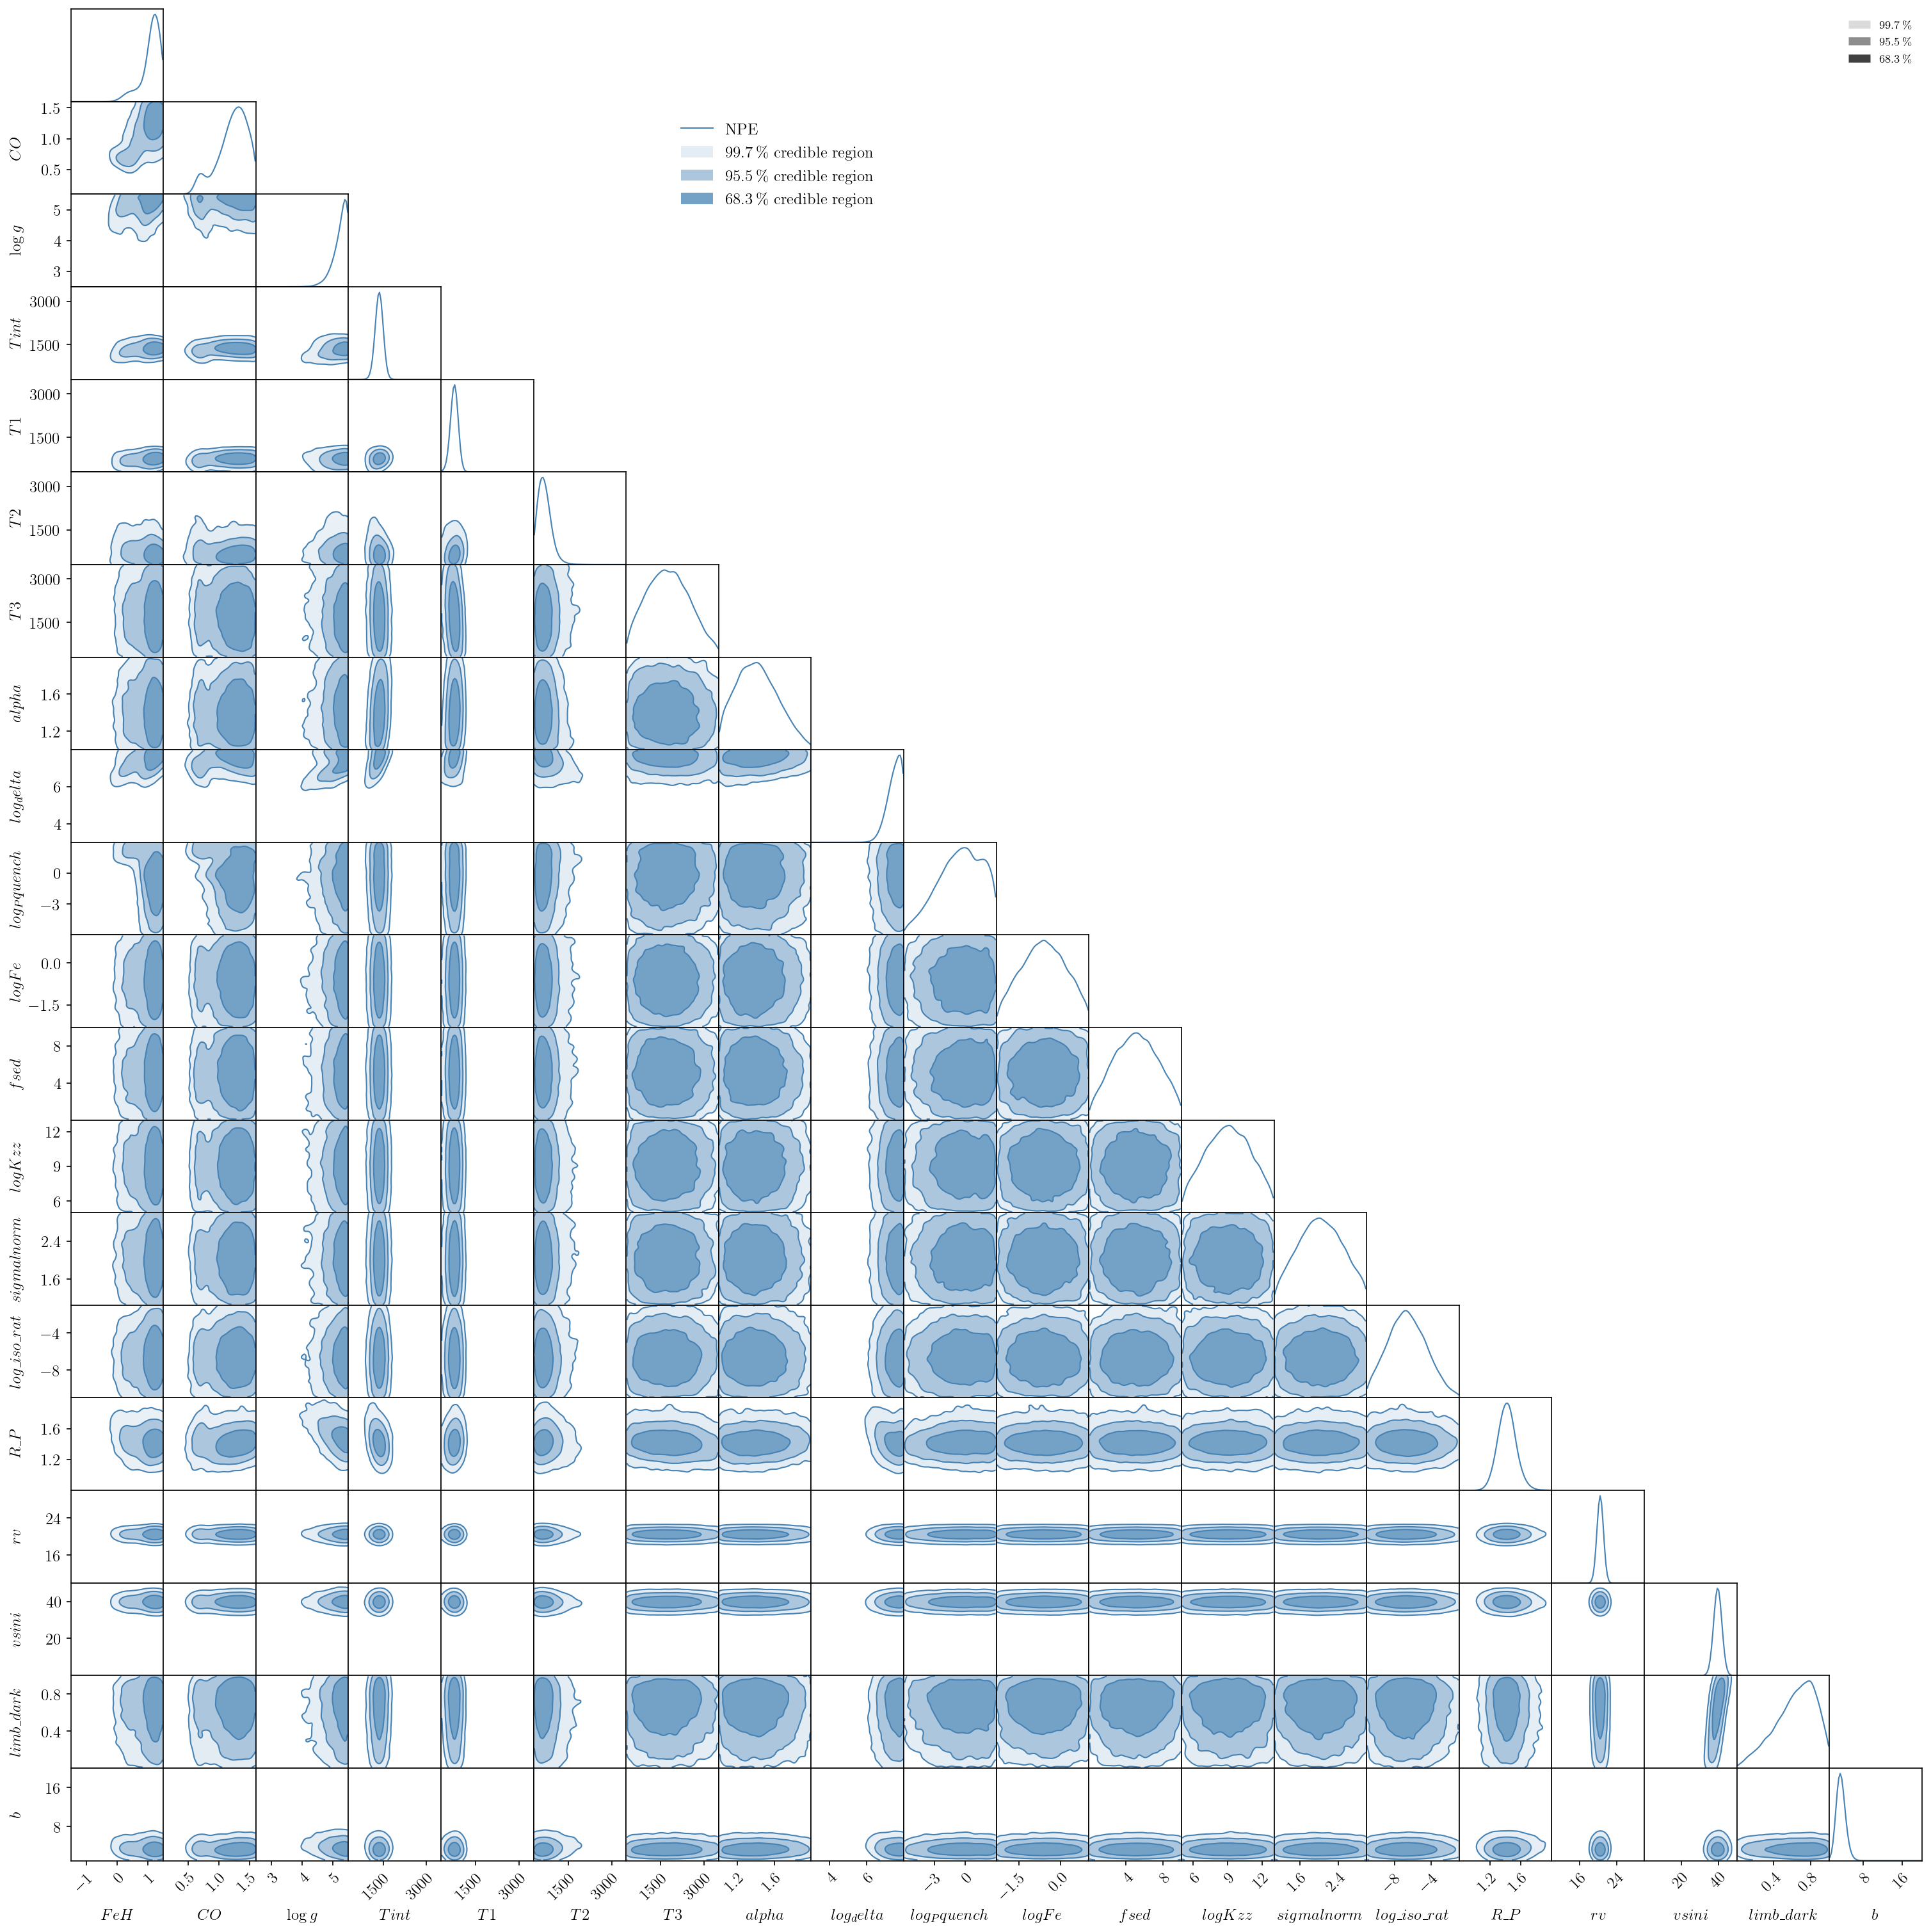

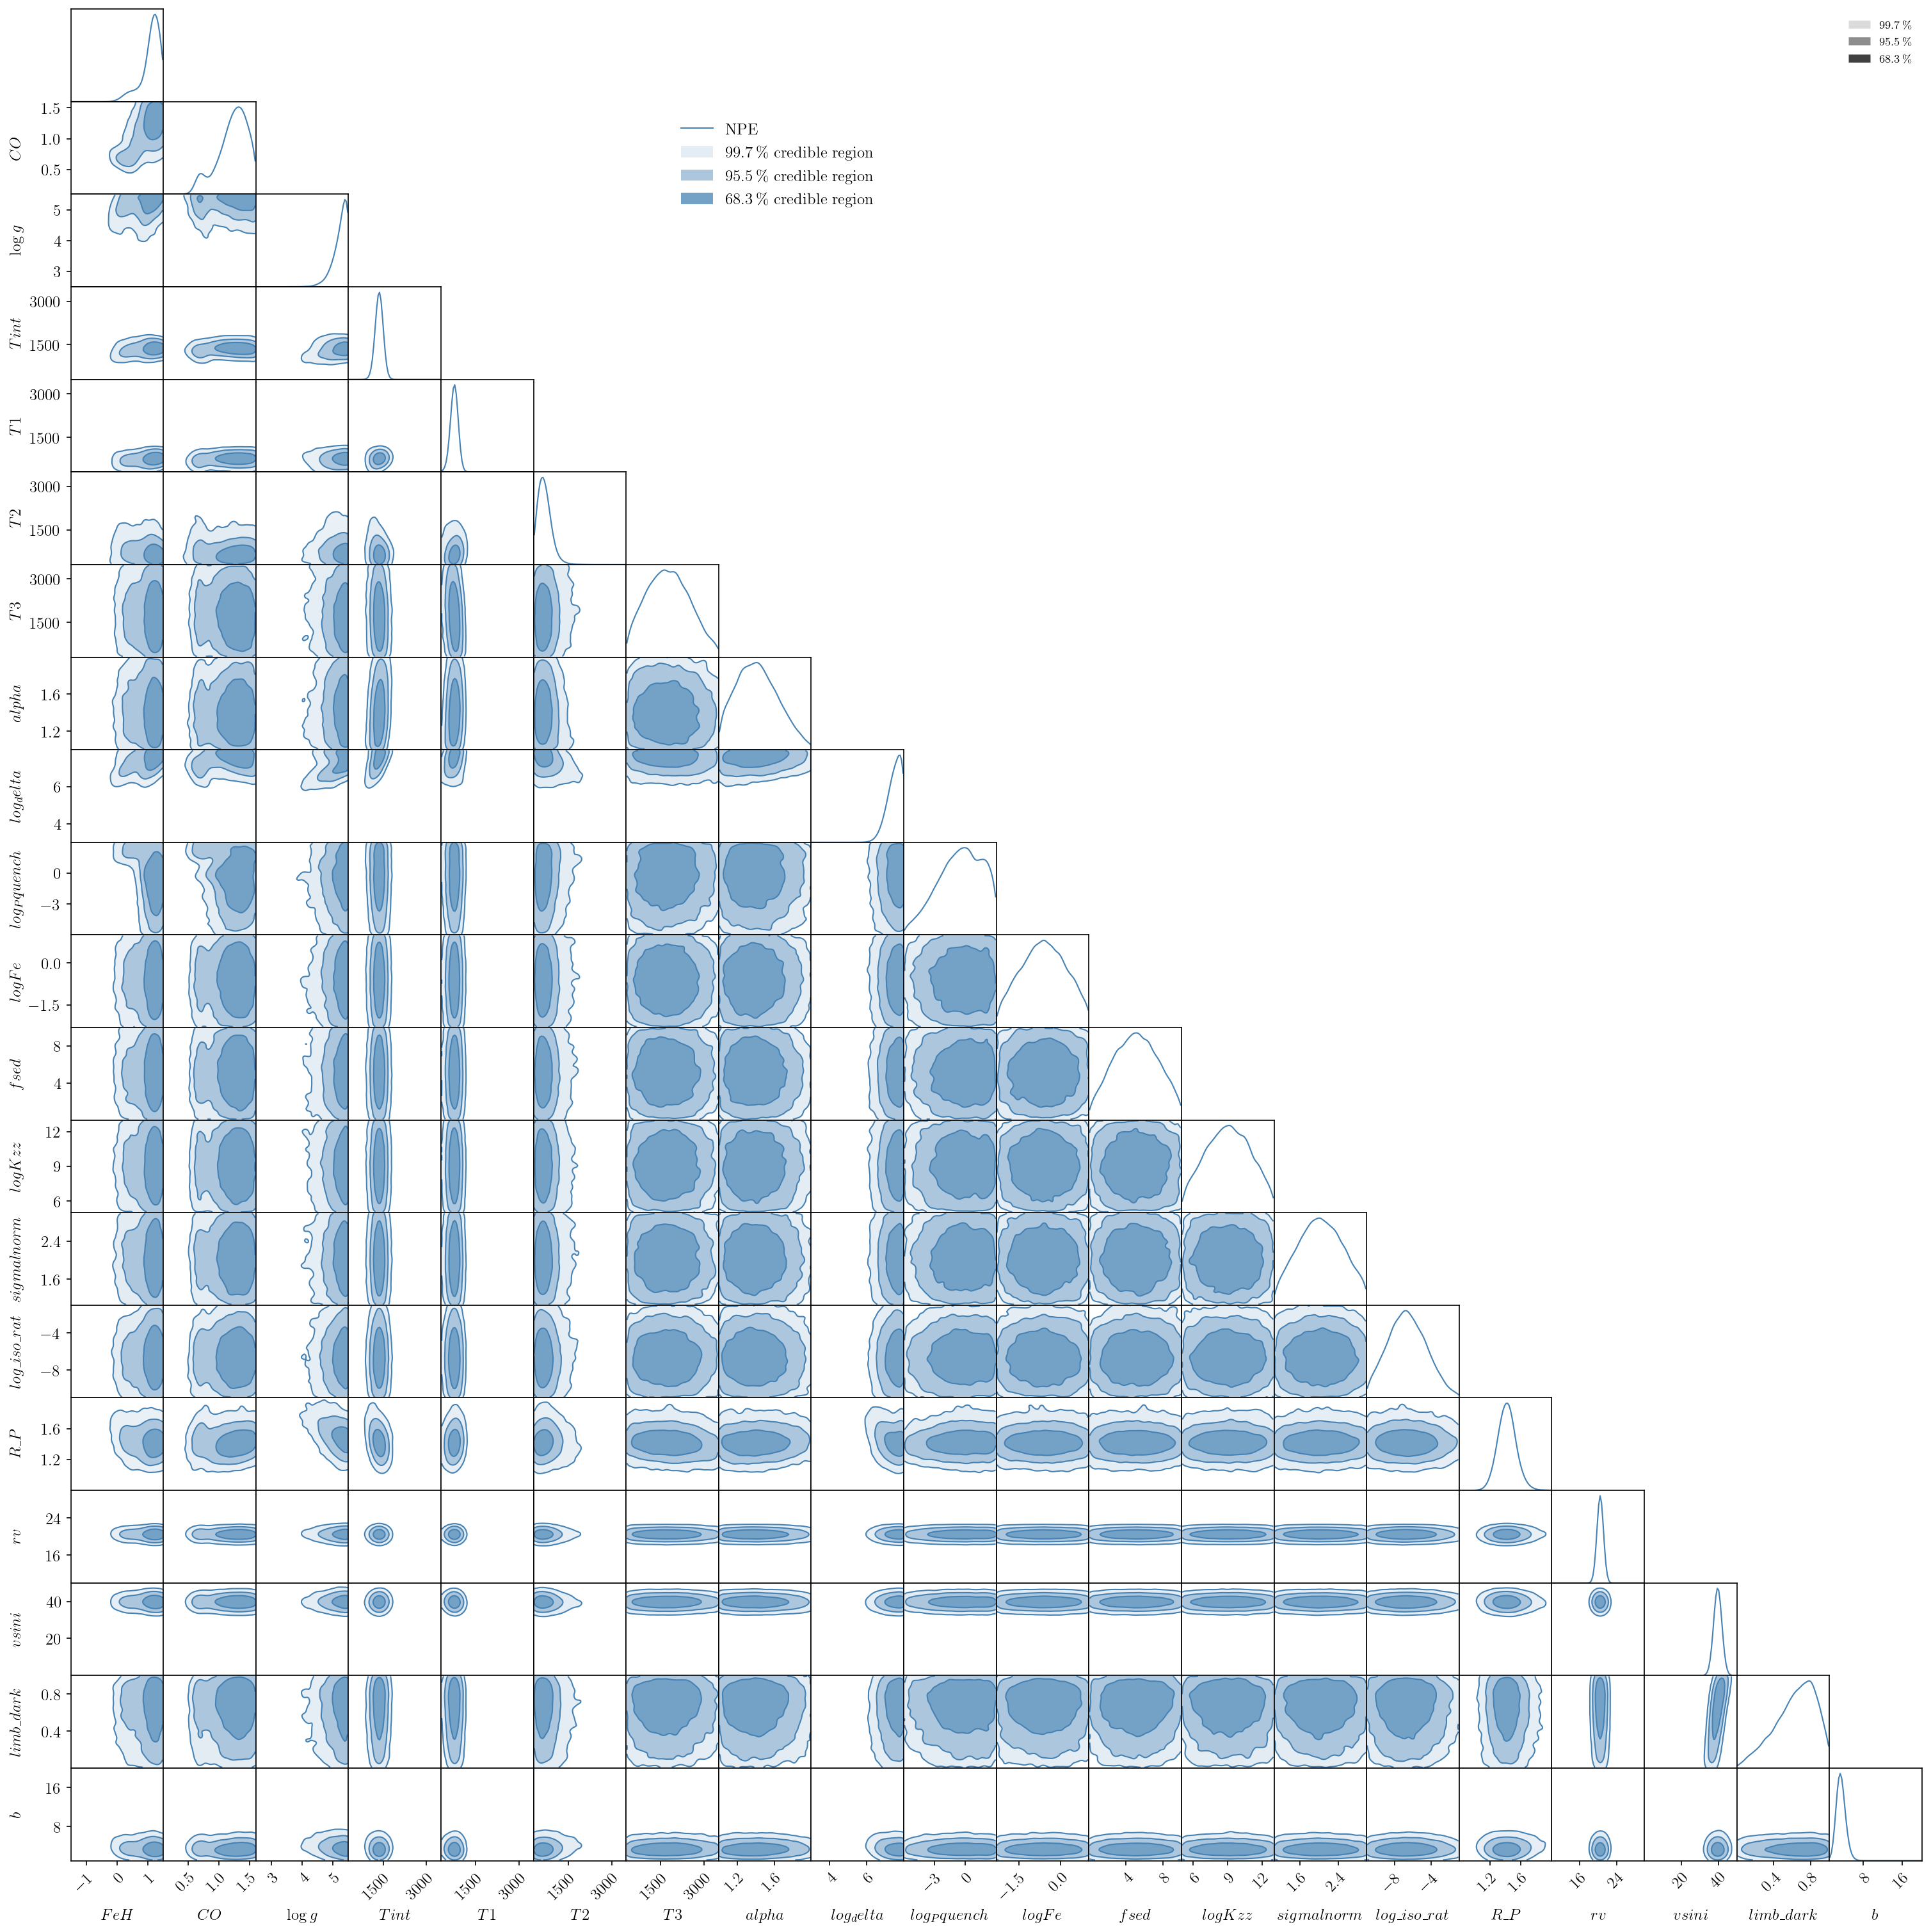

In [ ]:
corner_mod([th_df.values], legend=['NPE'], \
                color= ['steelblue'] , figsize=(20,20), \
             domain = (LOWER, UPPER), labels= LABELS) #


In [44]:
th_df_ = th_df.drop( columns= [7, 8, 10, 11, 12, 13, 14, 18, 19 ], axis=1)

In [45]:
th_df_

0         1         2            3           4            5   \
0      1.198782  0.831132  5.914190  1362.174606  723.038323   143.575930   
1      1.886791  1.767419  5.787471  1356.955285  738.065074   379.889770   
2      1.879085  1.899562  5.817237  1270.652390  746.958519   544.743530   
3      1.241187  1.629801  5.226819  1381.612974  855.413450   864.720670   
4      0.717029  1.135206  5.552192  1179.171511  572.350191   595.090949   
...         ...       ...       ...          ...         ...          ...   
20464  1.255670  1.592320  5.581162  1270.485201  594.369013   236.245714   
20465  0.543163  1.004025  5.550051  1353.181581  822.173738  1041.334586   
20466  0.664742  1.113796  5.598390  1494.938188  725.060979   517.844068   
20467  1.504682  1.240324  5.793684  1390.776845  872.224233   691.650524   
20468  1.442053  0.992226  5.992034  1345.643371  755.402027   492.924581   

                6         9         15         16         17  
0      3161.880675  0.434738  1.248732  20.420185  41.214969  
1      1540.586699  1.873686  1.301645  19.962796  37.916511  
2      1495.839929  1.597922  1.538767  20.632323  36.957980  
3      1538.673154  1.017400  1.568737  20.032012  41.134096  
4      1419.347837  1.732272  1.342841  20.443595  36.323582  
...            ...       ...       ...        ...        ...  
20464  2282.661097  0.989483  1.426721  20.148516  38.815126  
20465  1817.604555  4.998979  1.468652  20.462660  37.322571  
20466   511.071517  3.239208  1.350508  19.734063  40.767137  
20467  2174.771758 -1.900884  1.303342  20.287453  38.688711  
20468  1583.544280  0.504572  1.259216  20.002729  38.573917  

[20469 rows x 11 columns]

In [16]:
th_df_sam = pd.DataFrame(theta_sam)
th_df_sam

0         1         2            3           4           5   \
0    -0.272065  0.591780  5.282395  4693.238451  860.049283  609.558991   
1    -0.238464  0.598246  5.387477  4543.503664  839.246057  573.862761   
2    -0.237104  0.586893  5.403715  4907.756860  911.815268  651.660774   
3    -0.240041  0.593008  5.353033  4734.564451  915.860767  643.820093   
4    -0.248391  0.596758  5.344306  4929.544805  936.460389  684.256503   
...        ...       ...       ...          ...         ...         ...   
2986 -0.255831  0.593136  5.357171  4986.721087  892.939740  721.482021   
2987 -0.258578  0.592480  5.362988  4962.407482  885.100065  717.367477   
2988 -0.256215  0.591639  5.363198  4982.992206  890.195266  720.494781   
2989 -0.252826  0.594536  5.354802  4974.497128  881.461690  730.565203   
2990 -0.248025  0.592581  5.366868  4984.777200  883.900386  733.205503   

              6         7         8          9          10  
0     454.994112  1.070353  0.776357  22.660049  40.304610  
1     406.742978  1.088092  0.742900  22.727753  40.434223  
2     382.113669  1.048728  0.743326  22.531423  40.406156  
3     441.451895  1.087330  0.760046  22.548198  40.827446  
4     347.208668  1.082181  0.768861  22.610494  40.335625  
...          ...       ...       ...        ...        ...  
2986  609.619350  1.100856  0.774048  22.690843  40.307774  
2987  700.463946  1.096769  0.772318  22.686487  40.308205  
2988  670.292380  1.086168  0.769250  22.614232  40.305318  
2989  712.703562  1.088712  0.772668  22.640976  40.269166  
2990  713.780579  1.087711  0.767713  22.651372  40.307191  

[2991 rows x 11 columns]

In [8]:
# fig = corner_mod([th_df_.values, theta_sam], legend=['NPE', 'MultiNest'], \
#                     color= ['steelblue', 'orange'] , figsize=(12,12), \
#                  domain = (LOWER, UPPER), labels= LABELS) #

In [17]:
# for i in range(12):
#     plt.hist(th_df_sam.values[:,i])
#     plt.show()

In [57]:
from corner import corner

In [19]:
LABELS

('$FeH$',
 '$CO$',
 '$\\log g$',
 '$Tint$',
 '$T1$',
 '$T2$',
 '$T3$',
 '$alpha$',
 '$log_delta$',
 '$log_Pquench$',
 '$logFe$',
 '$fsed$',
 '$logKzz$',
 '$sigmalnorm$',
 '$log\\_iso\\_rat$',
 '$R\\_P$',
 '$rv$',
 '$vsini$',
 '$limb\\_dark$',
 '$b$')

In [20]:
labels = LABELS
print(labels)

('$FeH$', '$CO$', '$\\log g$', '$Tint$', '$T1$', '$T2$', '$T3$', '$alpha$', '$log_delta$', '$log_Pquench$', '$logFe$', '$fsed$', '$logKzz$', '$sigmalnorm$', '$log\\_iso\\_rat$', '$R\\_P$', '$rv$', '$vsini$', '$limb\\_dark$', '$b$')


In [21]:
7, 10, 11, 12, 13, 14, 18, 19

(7, 10, 11, 12, 13, 14, 18, 19)

In [42]:
labels = LABELS[:7] + LABELS[9:10] + LABELS[15:18] 

In [43]:
labels

('$FeH$',
 '$CO$',
 '$\\log g$',
 '$Tint$',
 '$T1$',
 '$T2$',
 '$T3$',
 '$log_Pquench$',
 '$R\\_P$',
 '$rv$',
 '$vsini$')

In [46]:
np.shape(th_df_), np.shape(th_df_sam)

((20469, 11), (2991, 11))

In [60]:
figure = corner(th_df_sam.values)
fig = corner(th_df_.values[:2991], fig=figure, color='red', labels = labels )


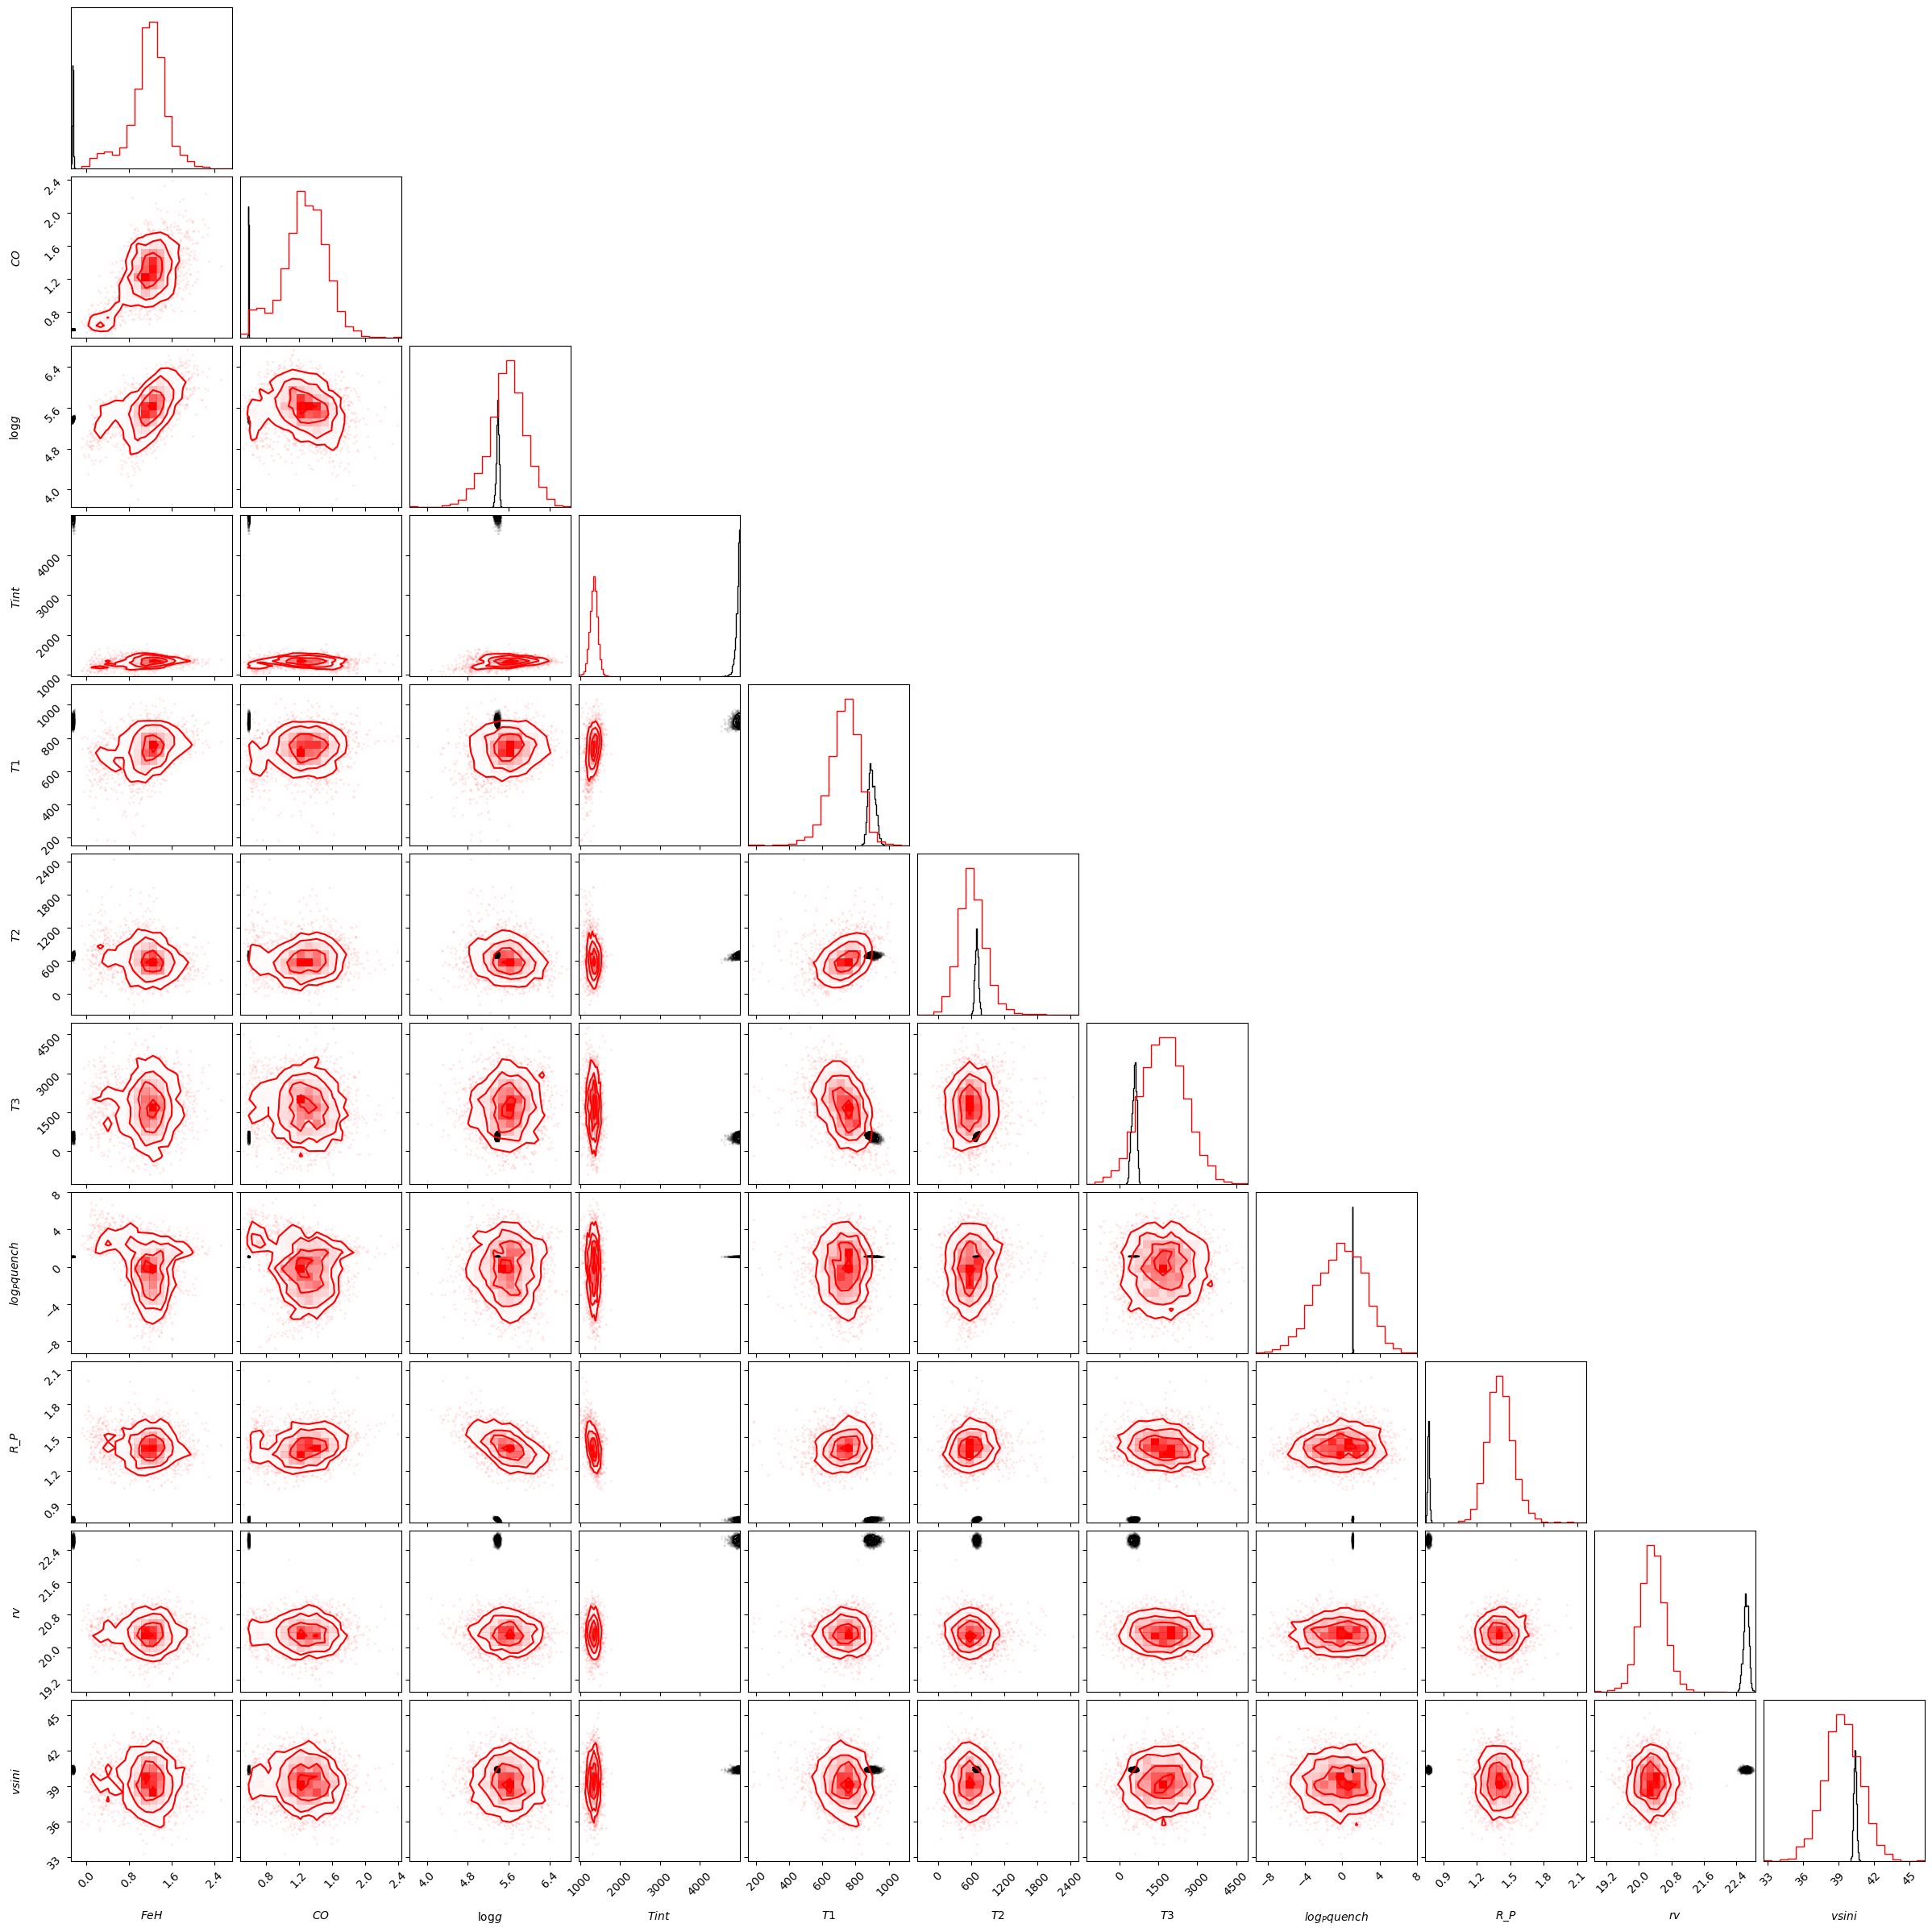

In [61]:
fig

In [64]:
# Highres/Sam/obs/DENIS_J0255_ergscm2nm
# Highres/observation/data/
import numpy as np 

wv = np.load('/home/mvasist/Highres/Sam/obs/DENIS_J0255_ergscm2nm/d_spec_wave.npy')
fl = np.load('/home/mvasist/Highres/Sam/obs/DENIS_J0255_ergscm2nm/d_spec_flux.npy')
err = np.load('/home/mvasist/Highres/Sam/obs/DENIS_J0255_ergscm2nm/d_spec_err.npy')


In [71]:
wv.flatten(), fl.flatten(), err.flatten()

(array([2321.53846792, 2321.54642203, 2321.554376  , ..., 2369.45566989,
        2369.46256922, 2369.46946836]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [77]:
plt.plot(fl.flatten())
plt.show()

FileNotFoundError: missing font metrics file: cmr8

<Figure size 960x720 with 1 Axes>

In [65]:
plt.rcParams.update(nice_rc(latex=True))
plt.figure(figsize=(15,7))
# plt.errorbar(x[0, 1], x[0,0], yerr= d.err**d.flux_scaling*25, color = 'steelblue', label = 'betsfit')
plt.plot(d.data_wavelengths_norm, d.flux*d.flux_scaling, color = 'black')
plt.plot(wv[0], fl, err)

plt.xlabel('Wavelength (mu)', fontsize = 20)
plt.ylabel('Planet flux Fv (meanflux Wm-2 um-1)', fontsize= 20)
plt.show()




ValueError: x and y can be no greater than 2-D, but have shapes (1, 3, 2048) and (1, 3, 2048)